In [1]:
#只需修改模型的部分，使用的是函数式API
#wide&deep模型涉及稀疏特征和密集特征
#稀疏特征是指用one-hot变量表示的，密集特征是例如词表中每个词都是一个向量表示的，如word2vet工具形成的
#wide&deep模型是输入有一半是wide模型，另一部分的输入包含密集特征

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.6
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [12]:
#函数式API
input = keras.layers.Input(shape = x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation='relu')(input)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
#需要合并密集特征和稀疏特征
contact = keras.layers.concatenate([input,hidden2])
output = keras.layers.Dense(1)(contact)

#形成模型
model = keras.models.Model(inputs=[input],outputs=[output])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics = ["accuracy"])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 28, 30)       870         input_4[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 28, 30)       930         dense_6[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 28, 58)       0           input_4[0][0]                    
                                                                 dense_7[0][0]              

In [14]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './wide_deep-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir,histogram_freq=1, profile_batch = 100000000),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 122us/sample - loss: 3.5573 - accuracy: 0.0712 - val_loss: 3.2804 - val_accuracy: 0.0632
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 3.2956 - accuracy: 0.0592 - val_loss: 3.2669 - val_accuracy: 0.0662
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 3.2895 - accuracy: 0.0642 - val_loss: 3.2437 - val_accuracy: 0.0720
Epoch 4/10
55000/55000 [==============================] - 5s 91us/sample - loss: 3.2542 - accuracy: 0.0644 - val_loss: 3.2620 - val_accuracy: 0.0614
Epoch 5/10
55000/55000 [==============================] - 5s 91us/sample - loss: 3.2548 - accuracy: 0.0653 - val_loss: 3.3435 - val_accuracy: 0.0722
Epoch 6/10
55000/55000 [==============================] - 5s 88us/sample - loss: 3.2581 - accuracy: 0.0623 - val_loss: 3.2487 - val_accuracy: 0.0576
Epoch 7/10
55000/55000 [==============================] 

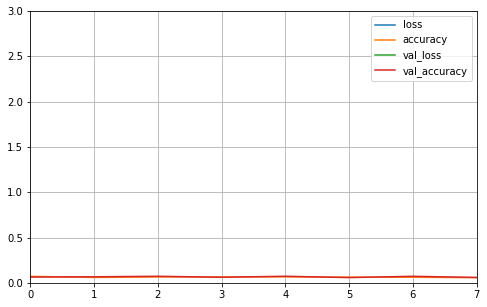

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))

In [16]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[3.2632187217712403, 0.06051429]